# CAP 6629: Reinforcement Learning Fall 2023 Course project 2

In [1]:
# Importing libraries

import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np

from keras.models import Sequential
from keras.layers import Dense
from keras.initializers import he_uniform

2023-10-29 15:52:36.316924: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

# Defining constants for the grid world
GRID_HEIGHT = 6
GRID_WIDTH = 6
START_STATE = (0, 0)
GOAL_STATE = (GRID_HEIGHT - 1, GRID_WIDTH - 1)
OBSTACLE_STATES = [(1, 2), (2, 3),(3,1) ,(3, 4), (4,1),(4, 4)]

# Defining possible actions
ACTIONS = ['UP', 'DOWN', 'LEFT', 'RIGHT']
NUM_ACTIONS = len(ACTIONS)

# Defining possible rewards
REWARD_MOVE = -1
REWARD_GOAL = 10
REWARD_OBSTACLE = -100

# Q-learning parameters
LEARNING_RATE = 0.1
DISCOUNT_FACTOR = 0.9
EXPLORATION_PROB = 0.2
NUM_EPISODES = 100
MAX_STEPS = 36
#INTERMEDIATE_Q_TABLE_INTERVAL = 100  # Display Q-table every 100 episodes

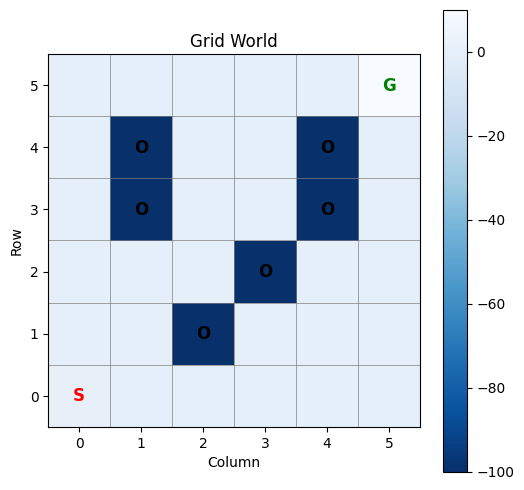

In [3]:

# Function for displaying the grid world
def display_grid():
    # Create the grid
    grid = np.zeros((GRID_HEIGHT, GRID_WIDTH))

    # Mark obstacles
    for obstacle in OBSTACLE_STATES:
        grid[obstacle] = -100

    # Mark start and goal
    grid[0, 0] = 1  # Start
    grid[GRID_HEIGHT - 1, GRID_WIDTH - 1] = 10  # Goal

    # Plot the 6x6 grid with lines and labels
    plt.figure(figsize=(6, 6))
    plt.imshow(grid, cmap='Blues_r', interpolation='none', origin='upper')

    # Plot vertical grid lines
    for i in range(GRID_WIDTH + 1):
        plt.axvline(i - 0.5, color='gray', linestyle='-', linewidth=0.5)

    # Plot horizontal grid lines
    for i in range(GRID_HEIGHT + 1):
        plt.axhline(i - 0.5, color='gray', linestyle='-', linewidth=0.5)

    # Adding labels
    for i in range(GRID_HEIGHT):
        for j in range(GRID_WIDTH):
            if grid[i, j] == 1:
                plt.text(j, i, 'S', ha='center', va='center', fontsize=12, fontweight='bold', color='red')
            elif grid[i, j] == 10:
                plt.text(j, i, 'G', ha='center', va='center', fontsize=12, fontweight='bold', color='green')
            elif grid[i, j] == -100:
                plt.text(j, i, 'O', ha='center', va='center', fontsize=12, fontweight='bold', color='black')

    plt.title('Grid World')
    plt.xlabel('Column')
    plt.ylabel('Row')
    plt.xticks(range(GRID_WIDTH))
    plt.yticks(range(GRID_HEIGHT))
    plt.gca().invert_yaxis()
    plt.colorbar()
    plt.show()

# Displaying the grid world
display_grid()


In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.initializers import he_uniform

# Define constants
GRID_WIDTH = 6
GRID_HEIGHT = 6
NUM_ACTIONS = 4
LEARNING_RATE = 0.1
DISCOUNT_FACTOR = 0.9
NUM_EPISODES = 100
MAX_STEPS = 50
EXPLORATION_PROB = 0.2

# Defining action names
ACTIONS = ["UP", "DOWN", "LEFT", "RIGHT"]

# Define grid world and obstacle states
grid = np.zeros((GRID_HEIGHT, GRID_WIDTH))
grid[5, 5] = 1  # Goal
grid[0, 0] = 0  # Start

# Defining Q-network model
def build_nn_model(input_shape, num_actions):
    model = Sequential()
    model.add(Dense(24, input_shape=input_shape, activation='relu', kernel_initializer=he_uniform()))
    model.add(Dense(num_actions, activation='linear', kernel_initializer=he_uniform()))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Initialize Q-network
input_shape = (2,)
model = build_nn_model(input_shape, NUM_ACTIONS)

# Function to select an action using the neural network
def select_action_nn(state, exploration_prob):
    if np.random.uniform(0, 1) < exploration_prob:
        return np.random.choice(NUM_ACTIONS)
    else:
        q_values = model.predict(state.reshape(1, -1))[0]
        return np.argmax(q_values)

# Q-learning algorithm using neural network approximation
def q_learning_nn(model, exploration_prob):
    mse_per_episode = []  # To store MSE per episode
    weights_trajectories = []  # To store weights trajectories

    for episode in range(NUM_EPISODES):
        state = np.array([0, 0])  # Starting position
        total_reward = 0
        episode_weight_trajectory = []

        for step in range(MAX_STEPS):
            action = select_action_nn(state, exploration_prob)

            # Perform the action and observe the new state and reward
            new_state = np.clip(state + np.array([
                [-1, 0],  # UP
                [1, 0],   # DOWN
                [0, -1],  # LEFT
                [0, 1]    # RIGHT
            ])[action], 0, [GRID_HEIGHT - 1, GRID_WIDTH - 1])

            reward = grid[new_state[0], new_state[1]]
            total_reward += reward

            # Calculate the Q-learning target
            q_values_current = model.predict(state.reshape(1, -1))[0]
            q_values_next = model.predict(new_state.reshape(1, -1))[0]
            q_target = q_values_current.copy()
            q_target[action] = reward + DISCOUNT_FACTOR * np.max(q_values_next)

            # Update the Q-value using Q-learning update rule
            model.fit(state.reshape(1, -1), q_target.reshape(1, -1), epochs=1, verbose=0)

            # Track weights trajectories
            episode_weight_trajectory.append(model.get_weights())

            state = new_state

            # Check if reached the goal
            if new_state[0] == GRID_HEIGHT - 1 and new_state[1] == GRID_WIDTH - 1:
                break

        # Update exploration probability
        exploration_prob = max(0.1, exploration_prob * 0.99)

        # Calculate the Mean Squared Error (MSE) for this episode
        mse = np.mean(np.square(q_values_current - q_target))
        mse_per_episode.append(mse)

        # Store the weights trajectory for this episode
        weights_trajectories.append(episode_weight_trajectory)

        # Display episode and total reward
        print(f"Episode {episode + 1}/{NUM_EPISODES}, Total Reward: {total_reward}")

    return mse_per_episode, weights_trajectories

# Run Q-learning using neural network approximation
mse_per_episode, weights_trajectories = q_learning_nn(model, EXPLORATION_PROB)


1/1 [==============================] - 0s 21ms/step
Episode 1/100, Total Reward: 0.0
1/1 [==============================] - 0s 31ms/step
Episode 2/100, Total Reward: 0.0
1/1 [==============================] - 0s 25ms/step
Episode 3/100, Total Reward: 0.0
1/1 [==============================] - 0s 28ms/step
Episode 4/100, Total Reward: 0.0
1/1 [==============================] - 0s 34ms/step
Episode 5/100, Total Reward: 0.0
1/1 [==============================] - 0s 36ms/step
Episode 6/100, Total Reward: 0.0
1/1 [==============================] - 0s 31ms/step
Episode 7/100, Total Reward: 0.0
1/1 [==============================] - 0s 45ms/step
Episode 8/100, Total Reward: 0.0
1/1 [==============================] - 0s 26ms/step
Episode 9/100, Total Reward: 0.0
1/1 [==============================] - 0s 50ms/step
Episode 10/100, Total Reward: 0.0
1/1 [==============================] - 0s 32ms/step
Episode 11/100, Total Reward: 0.0
1/1 [==============================] - 0s 89ms/step
Episode 12/

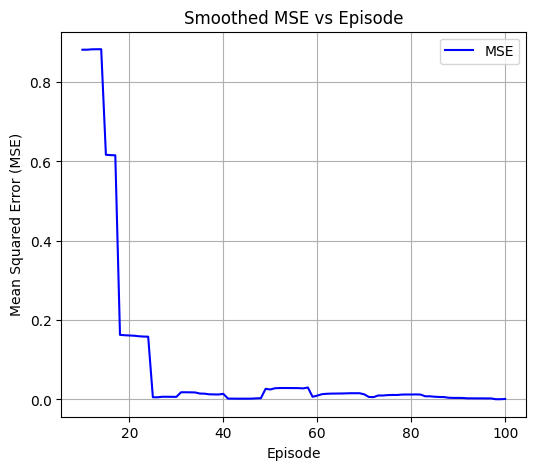

In [18]:


# Data smoothing for visualization
def smooth_data(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

# Smooth the MSE values using a moving average with a window size of 10
window_size = 10
smoothed_mse = smooth_data(mse_per_episode, window_size)

# Create an array to represent the episode numbers
episode_numbers = list(range(window_size, NUM_EPISODES + 1))

# Plot the smoothed MSE vs Episode
plt.figure(figsize=(6, 5))
plt.plot(episode_numbers, smoothed_mse, label='MSE', color='b')
plt.xlabel('Episode')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Smoothed MSE vs Episode')
plt.legend()
plt.grid(True)

# Display the MSE vs Episode plot
plt.show()


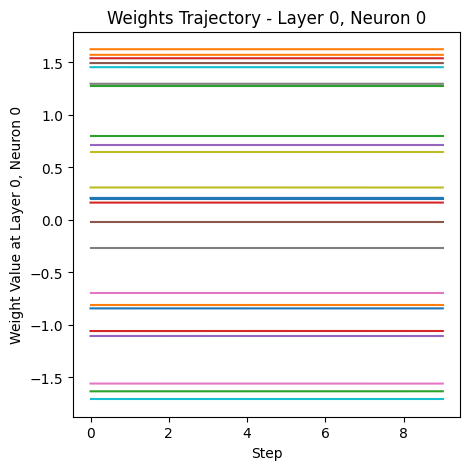

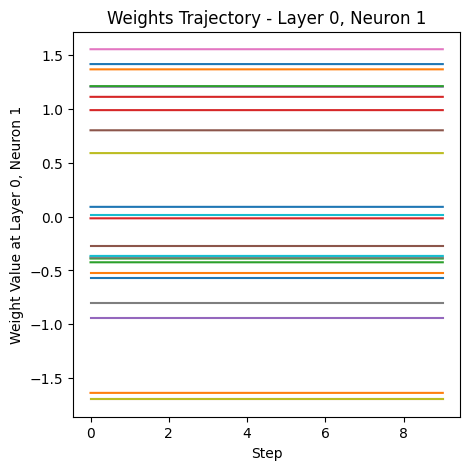

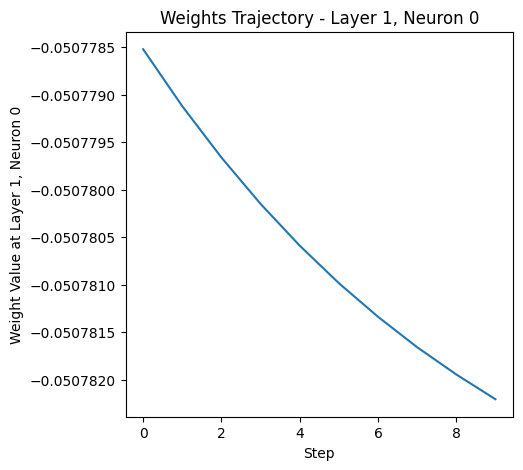

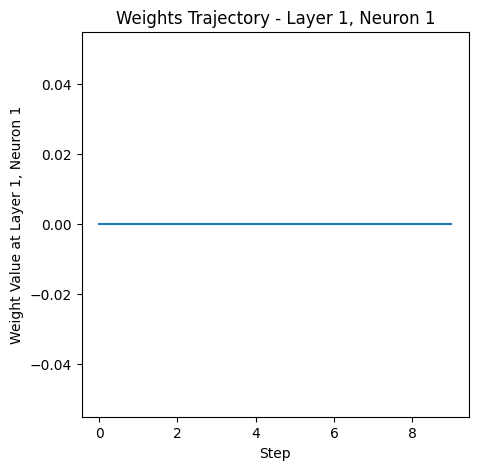

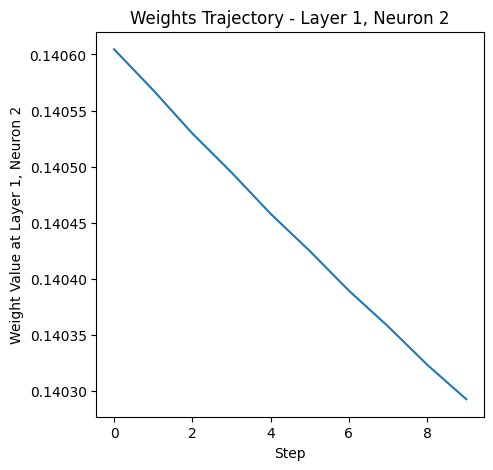

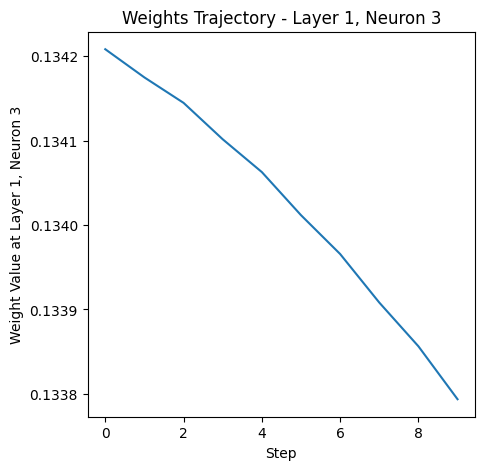

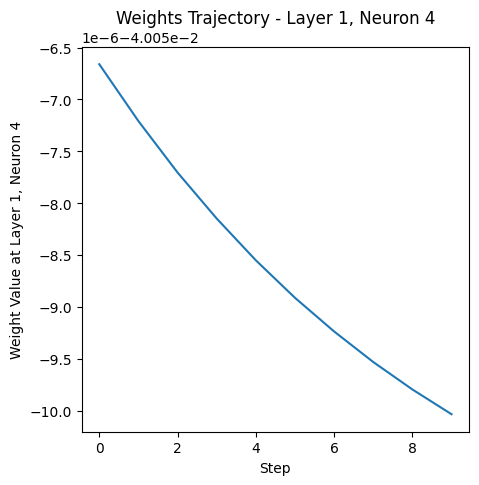

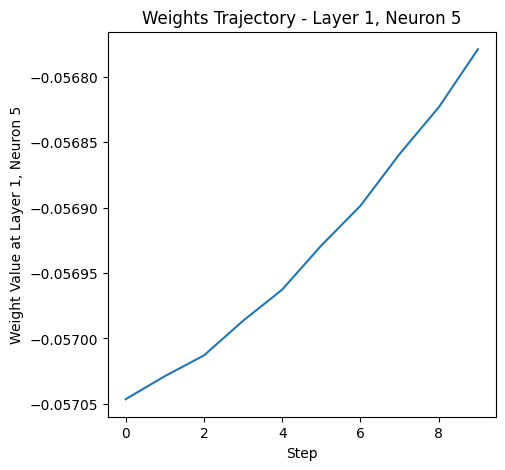

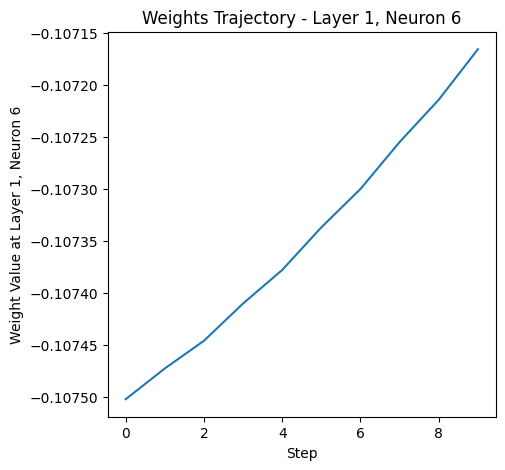

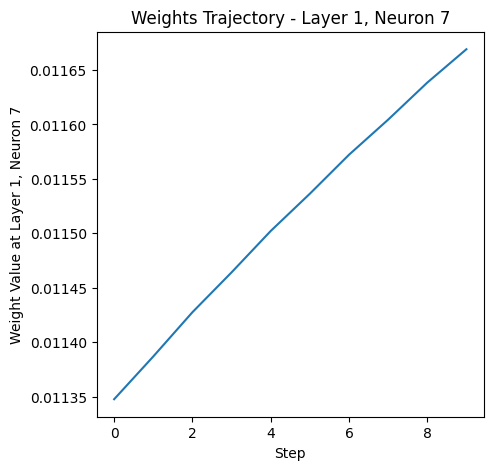

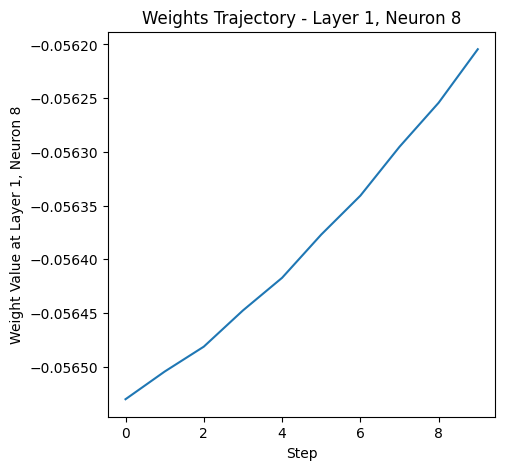

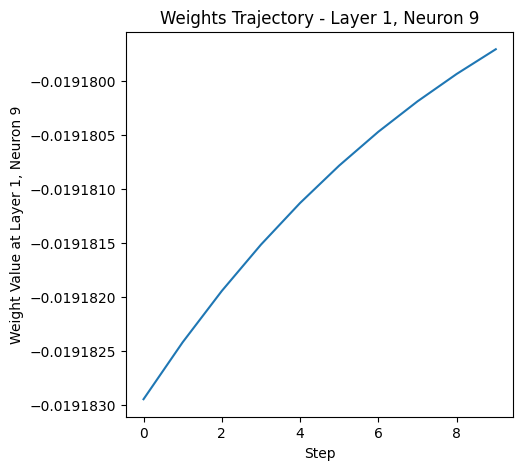

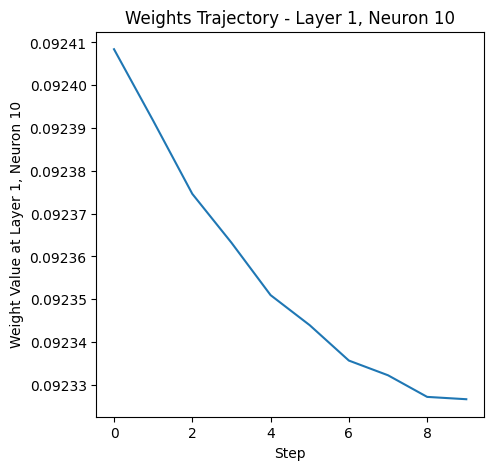

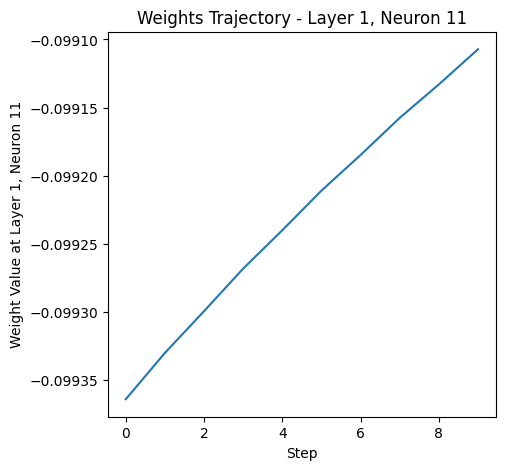

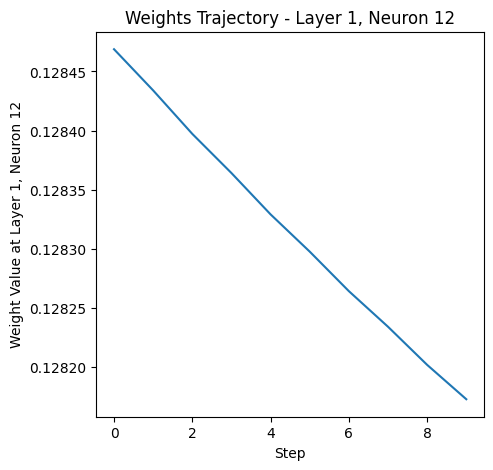

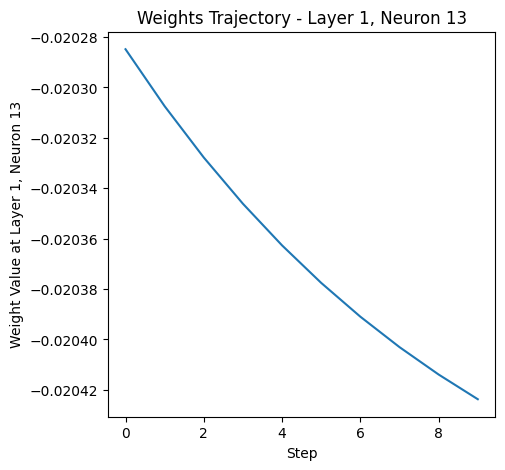

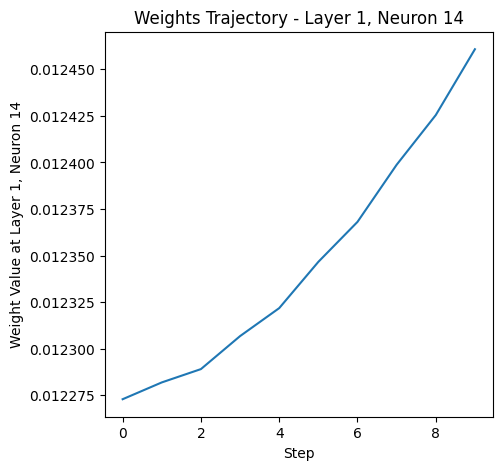

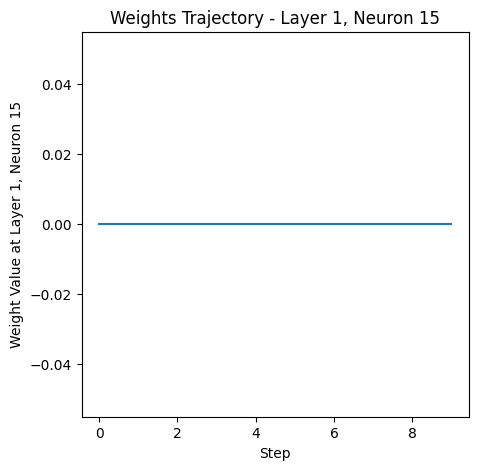

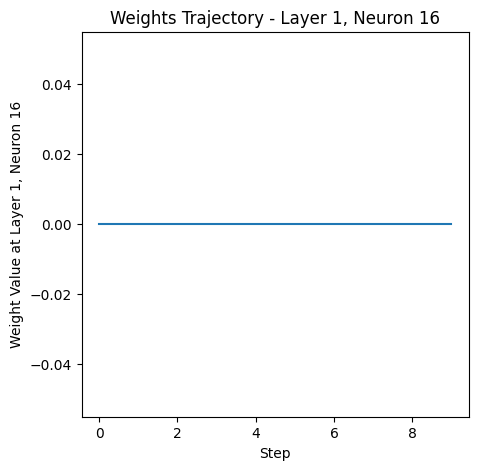

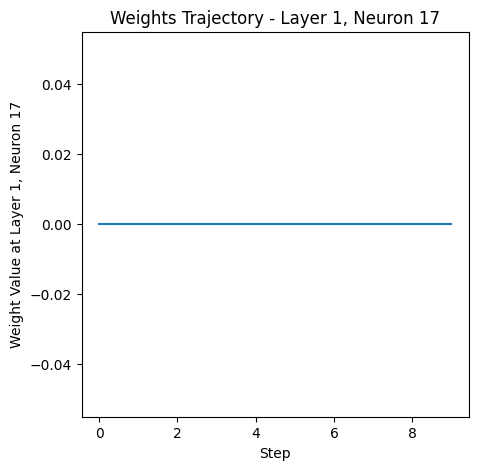

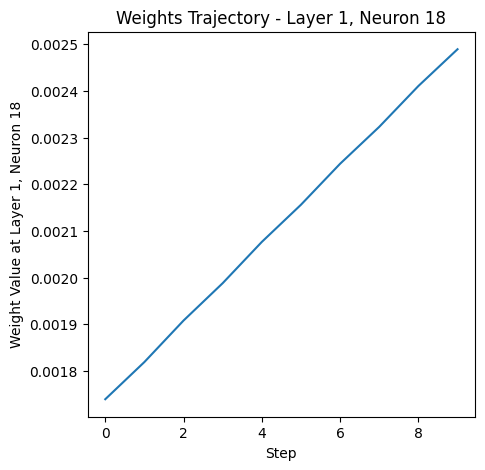

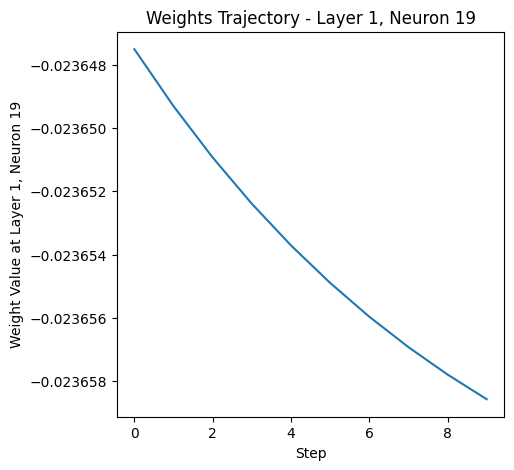

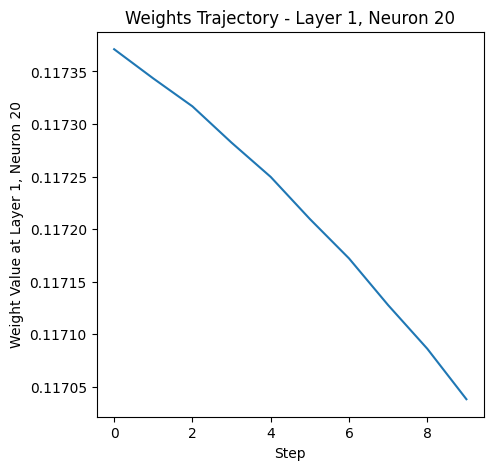

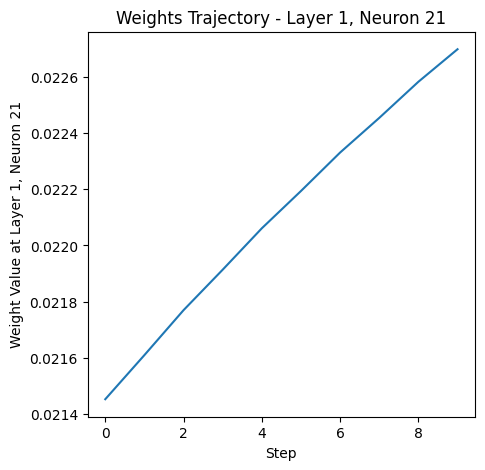

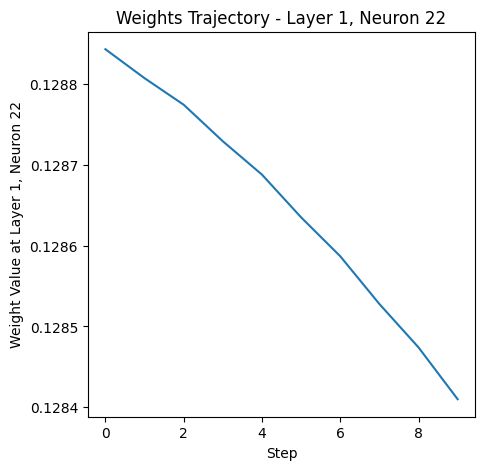

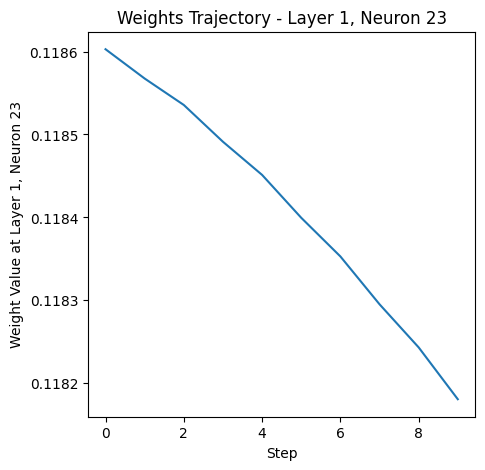

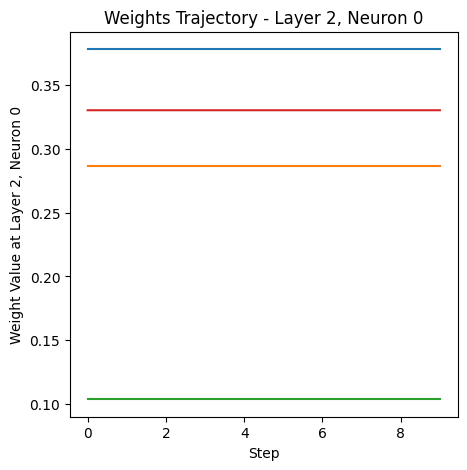

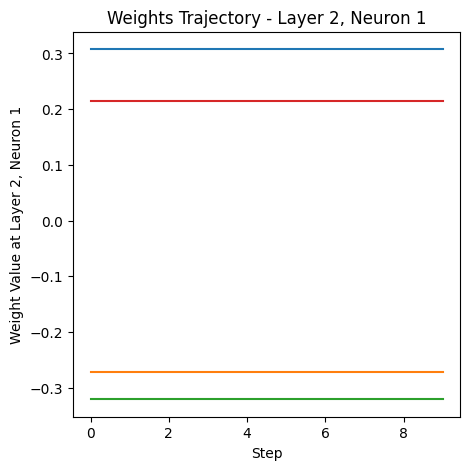

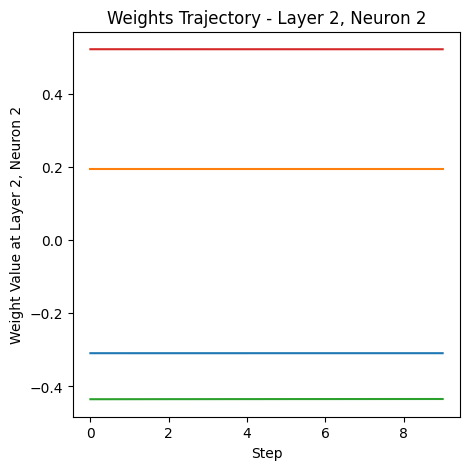

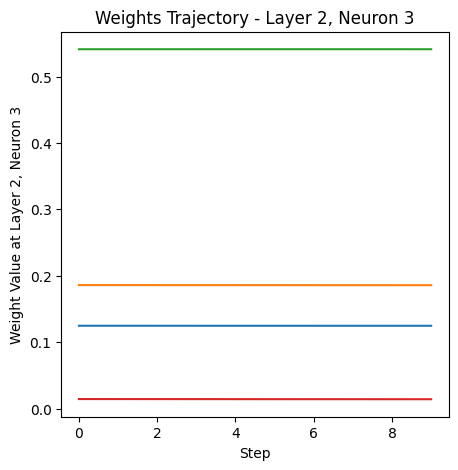

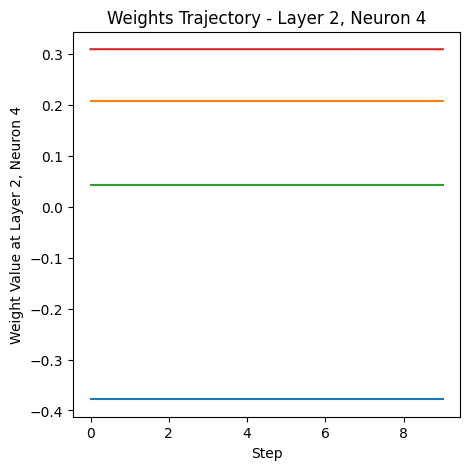

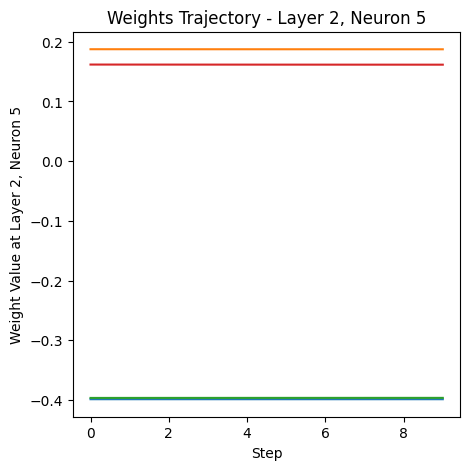

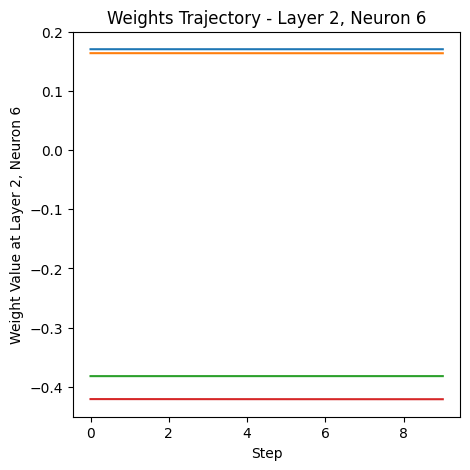

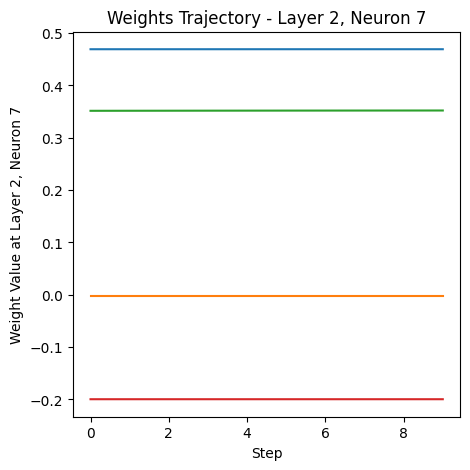

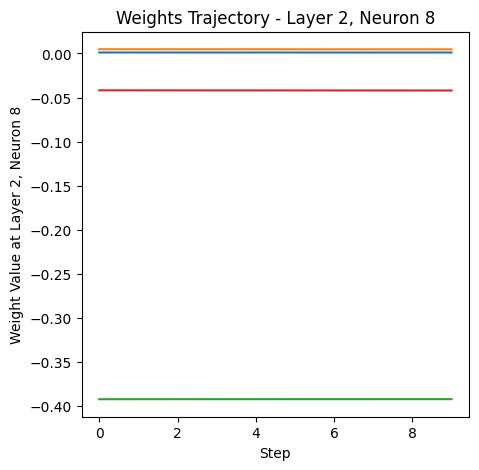

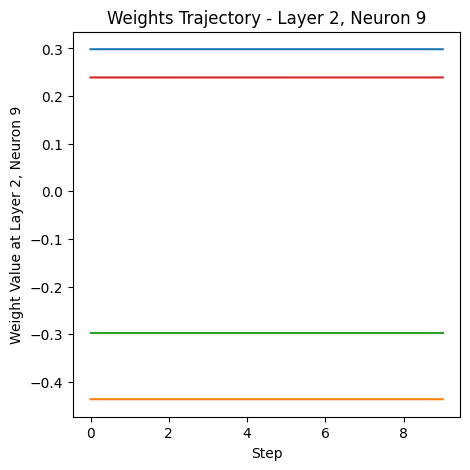

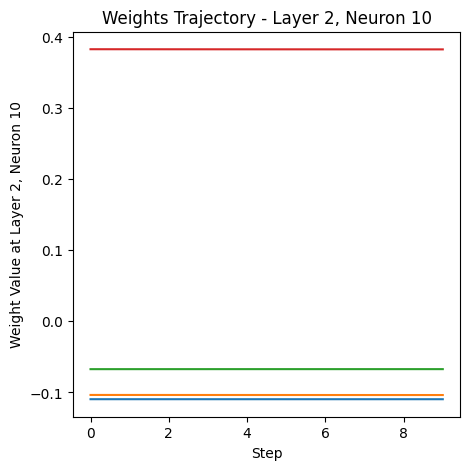

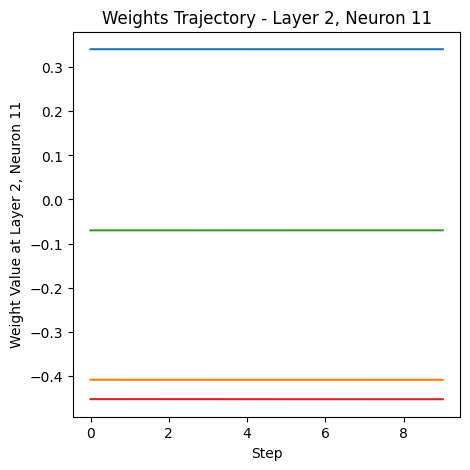

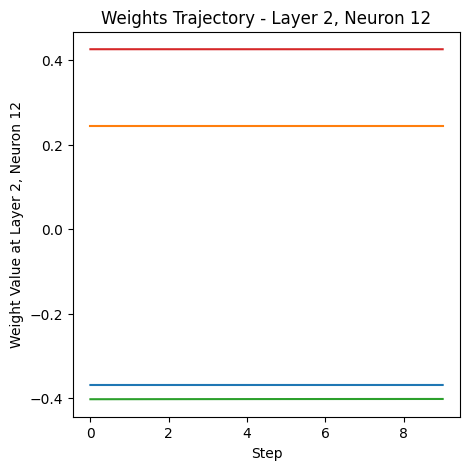

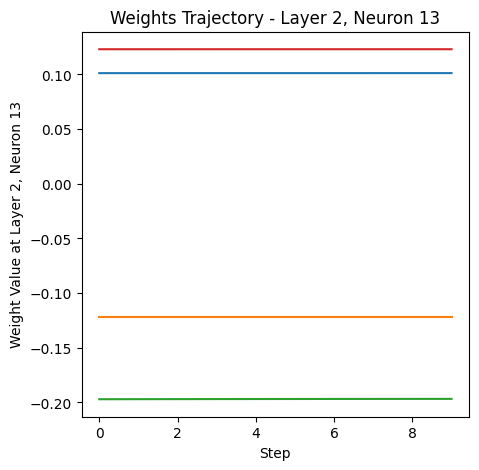

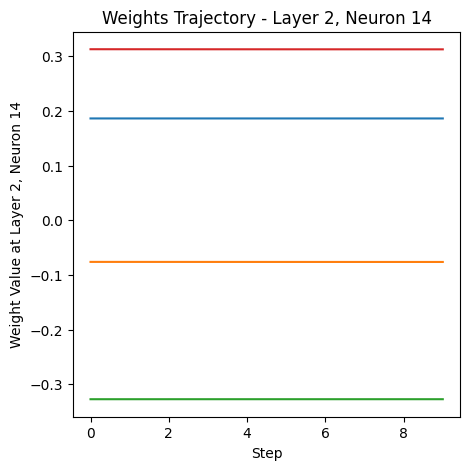

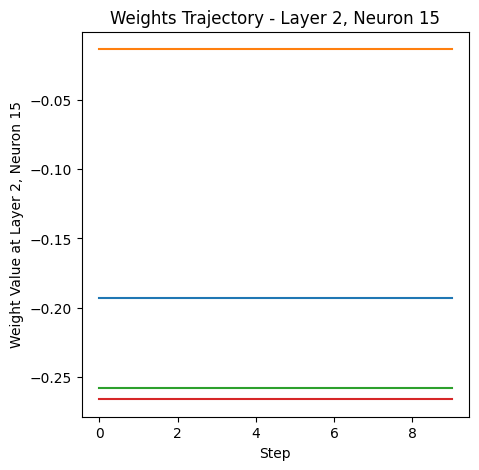

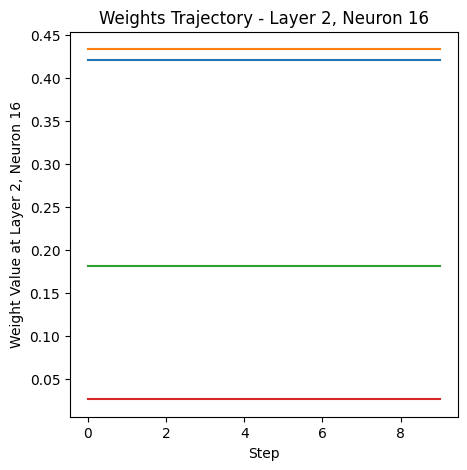

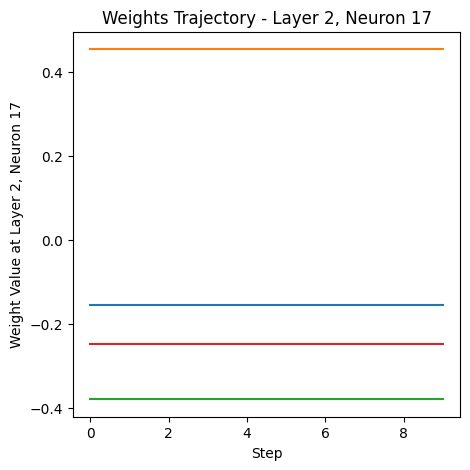

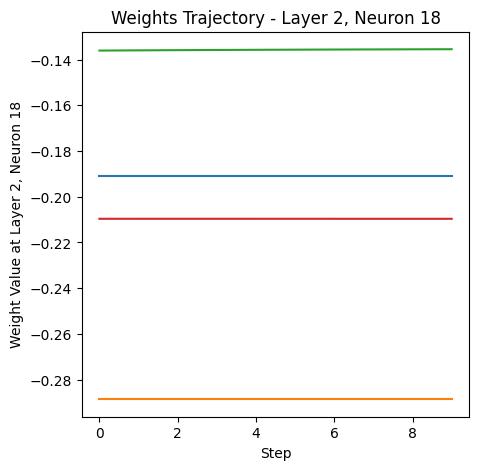

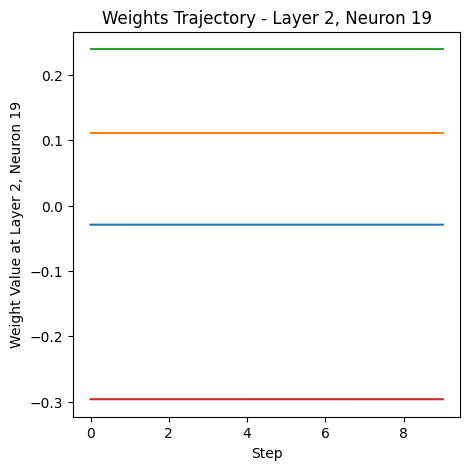

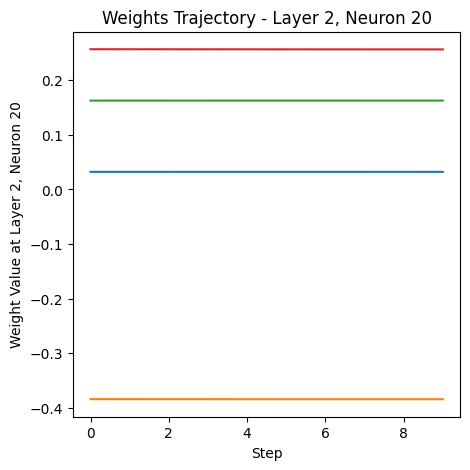

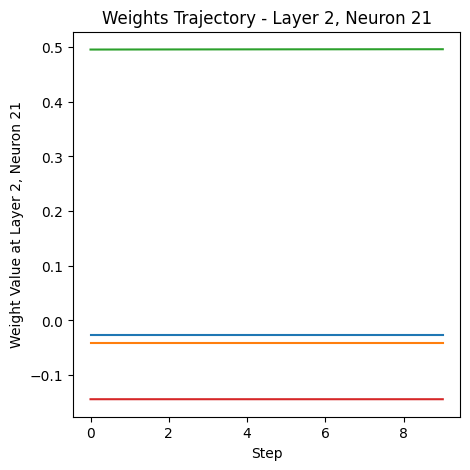

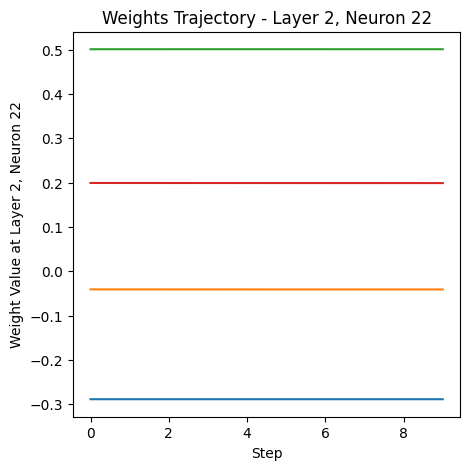

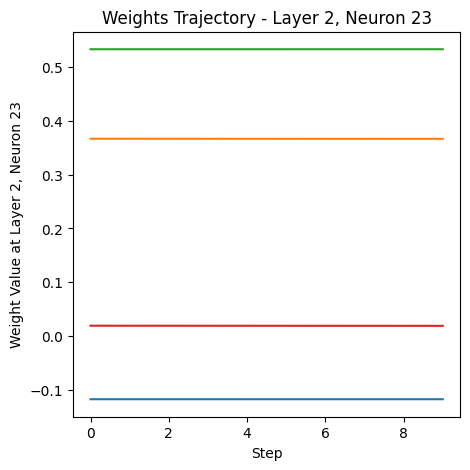

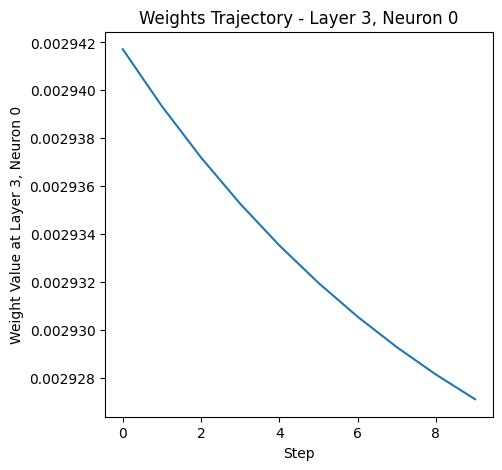

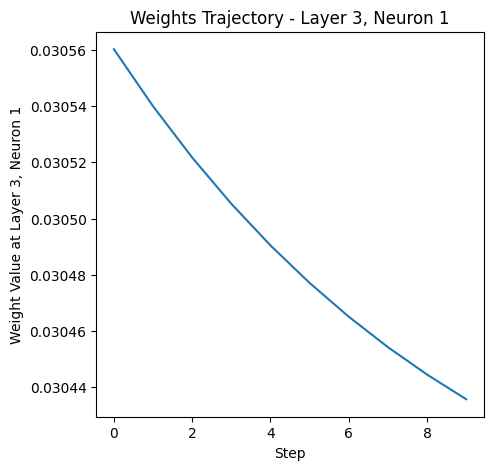

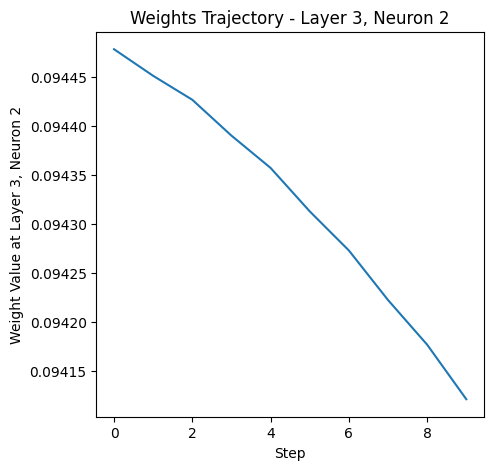

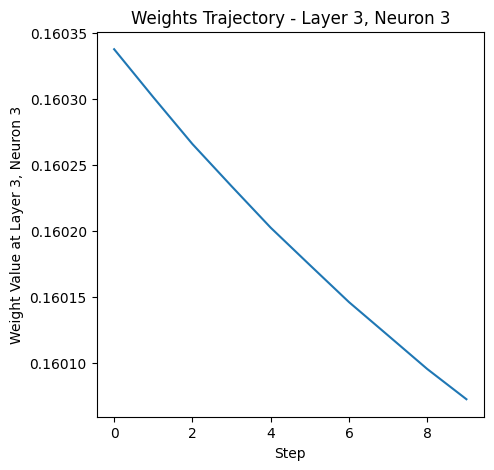

In [7]:
# Plot the weight trajectory for the last episode
last_episode_weight_trajectory = weights_trajectories[-1]

for layer in range(len(last_episode_weight_trajectory[0])):
    for i in range(len(last_episode_weight_trajectory[0][layer])):
        weights_at_layer_i = [weights[layer][i] for weights in last_episode_weight_trajectory]
        
        plt.figure(figsize=(5, 5))
        plt.plot(weights_at_layer_i)
        plt.xlabel('Step')
        plt.ylabel(f'Weight Value at Layer {layer}, Neuron {i}')
        plt.title(f'Weights Trajectory - Layer {layer}, Neuron {i}')
        plt.show()


In [9]:

# Print the initial V-values and Q-values
print("Initial V-values:")
print(V_values)

print("\nInitial Q-values:")
for state, q_values in Q_values.items():
    print(f"State {state}: Q-values {q_values}")


Initial V-values:
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]

Initial Q-values:
State (0, 0): Q-values [-0.0156393   0.057835   -0.00049557  0.03023924]
State (0, 1): Q-values [ 0.48948264 -1.0208143   0.4334507   0.74094313]
State (0, 2): Q-values [ 1.0128528  -2.1149983   0.86931753  1.442545  ]
State (0, 3): Q-values [ 1.5362228 -3.209183   1.3051839  2.1441467]
State (0, 4): Q-values [ 2.0595927 -4.3033676  1.7410508  2.8457487]
State (0, 5): Q-values [ 2.582963  -5.3975525  2.176917   3.5473504]
State (1, 0): Q-values [-0.05899684 -1.3720101   0.8507135   1.1990556 ]
State (1, 1): Q-values [ 0.34073514 -2.5984023   0.67081535  0.85784906]
State (1, 2): Q-values [ 1.2361994 -3.539463   0.8233883  1.0420463]
State (1, 3): Q-values [ 1.819923  -4.699789   1.1411877  1.723825 ]
State (1, 4): Q-values [ 2.3736143 -5.880891   1.4709455  2.4582787]
State (1, 5): Q-values [ 2.9232223 -7.021513   1.8363674 

In [14]:
# Display the learned Q-values and V-values using Neural Network Approximation:
print("\nLearned Q-values and V-values using Neural Network Approximation:\n")
for i in range(GRID_HEIGHT):
    for j in range(GRID_WIDTH):
        state = np.array([i, j])
        q_values = model.predict(state.reshape(1, -1))[0]
        v_value = np.max(q_values)  # Calculate V-value as the maximum Q-value
        print(f"State ({i}, {j}):")
        for action in range(NUM_ACTIONS):
            print(f"  Action {ACTIONS[action]}: Q-value {q_values[action]}")
        print(f" \n V-value {v_value}\n")



Learned Q-values and V-values using Neural Network Approximation:

1/1 [==============================] - 0s 54ms/step
State (0, 0):
  Action UP: Q-value -0.015639301389455795
  Action DOWN: Q-value 0.05783499777317047
  Action LEFT: Q-value -0.0004955725744366646
  Action RIGHT: Q-value 0.03023923933506012
 
 V-value 0.05783499777317047

1/1 [==============================] - 0s 23ms/step
State (0, 1):
  Action UP: Q-value 0.4894826412200928
  Action DOWN: Q-value -1.020814299583435
  Action LEFT: Q-value 0.43345069885253906
  Action RIGHT: Q-value 0.7409431338310242
 
 V-value 0.7409431338310242

1/1 [==============================] - 0s 20ms/step
State (0, 2):
  Action UP: Q-value 1.0128527879714966
  Action DOWN: Q-value -2.1149983406066895
  Action LEFT: Q-value 0.8693175315856934
  Action RIGHT: Q-value 1.4425450563430786
 
 V-value 1.4425450563430786

1/1 [==============================] - 0s 20ms/step
State (0, 3):
  Action UP: Q-value 1.5362228155136108
  Action DOWN: Q-value

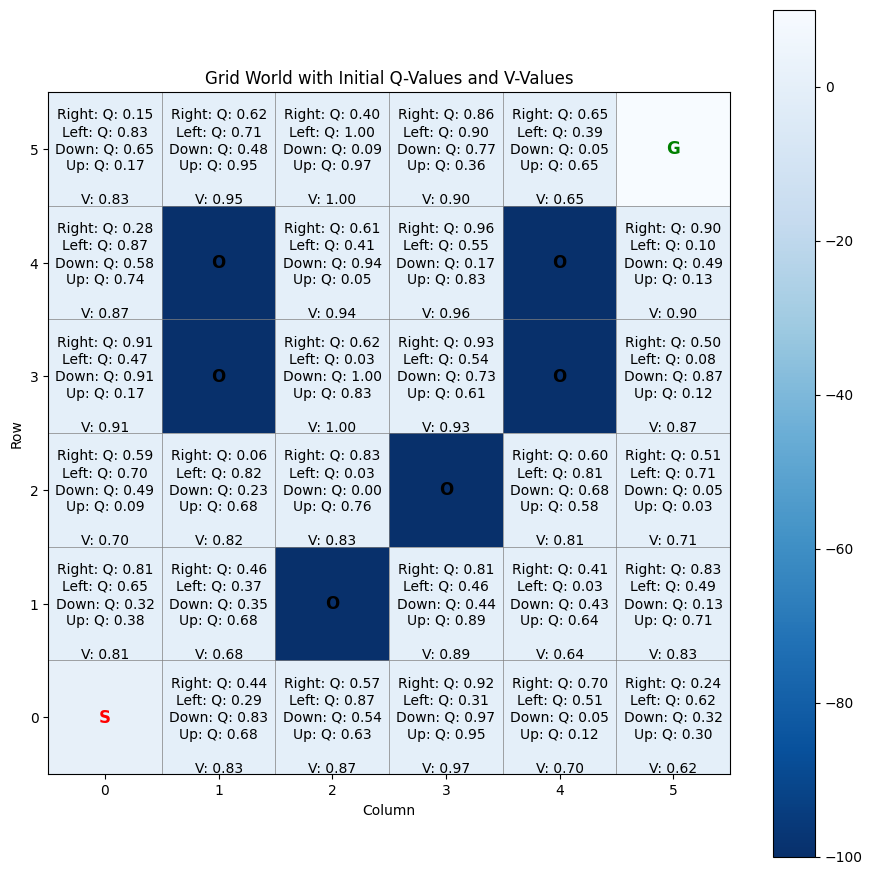

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Defining grid parameters and obstacle states
GRID_HEIGHT = 6
GRID_WIDTH = 6
OBSTACLE_STATES = [(1, 2), (2, 3),(3,1) ,(3, 4), (4,1),(4, 4)]
ACTIONS = ['Up', 'Down', 'Left', 'Right']
NUM_ACTIONS = len(ACTIONS)

# Defining a function to display the grid world with values
def display_grid_with_values(q_values, v_values):
    # Create the grid
    grid = np.zeros((GRID_HEIGHT, GRID_WIDTH))

    # Mark obstacles
    for obstacle in OBSTACLE_STATES:
        grid[obstacle] = -100

    # Mark start and goal
    grid[0, 0] = 1  # Start
    grid[GRID_HEIGHT - 1, GRID_WIDTH - 1] = 10  # Goal

    # Create a larger figure for better visualization
    plt.figure(figsize=(11, 11))

    # Plot the grid with values
    plt.imshow(grid, cmap='Blues_r', interpolation='none', origin='upper')
    for i in range(GRID_WIDTH + 1):
        plt.axvline(i - 0.5, color='gray', linestyle='-', linewidth=0.5)
    for i in range(GRID_HEIGHT + 1):
        plt.axhline(i - 0.5, color='gray', linestyle='-', linewidth=0.5)

    for i in range(GRID_HEIGHT):
        for j in range(GRID_WIDTH):
            if grid[i, j] == 1:
                plt.text(j, i, 'S', ha='center', va='center', fontsize=12, fontweight='bold', color='red')
            elif grid[i, j] == 10:
                plt.text(j, i, 'G', ha='center', va='center', fontsize=12, fontweight='bold', color='green')
            elif grid[i, j] == -100:
                plt.text(j, i, 'O', ha='center', va='center', fontsize=12, fontweight='bold', color='black')
            else:
                for a, action in enumerate(ACTIONS):
                    plt.text(j, i + 0.15 * (a - 1), f'{action}: Q: {q_values[i, j, a]:.2f}', ha='center', va='center', fontsize=10, color='black')
                plt.text(j, i - 0.15 * (NUM_ACTIONS - 1), f'V: {v_values[i, j]:.2f}', ha='center', va='center', fontsize=10, color='black')

    plt.title('Grid World with Initial Q-Values and V-Values')
    plt.xlabel('Column')
    plt.ylabel('Row')
    plt.xticks(range(GRID_WIDTH))
    plt.yticks(range(GRID_HEIGHT))
    plt.gca().invert_yaxis()
    plt.colorbar()

# Sample initial Q-values and V-values
initial_q_values = np.random.rand(GRID_HEIGHT, GRID_WIDTH, NUM_ACTIONS)
initial_v_values = np.max(initial_q_values, axis=2)

# Display the grid world with initial Q-values and V-values
display_grid_with_values(initial_q_values, initial_v_values)

plt.show()


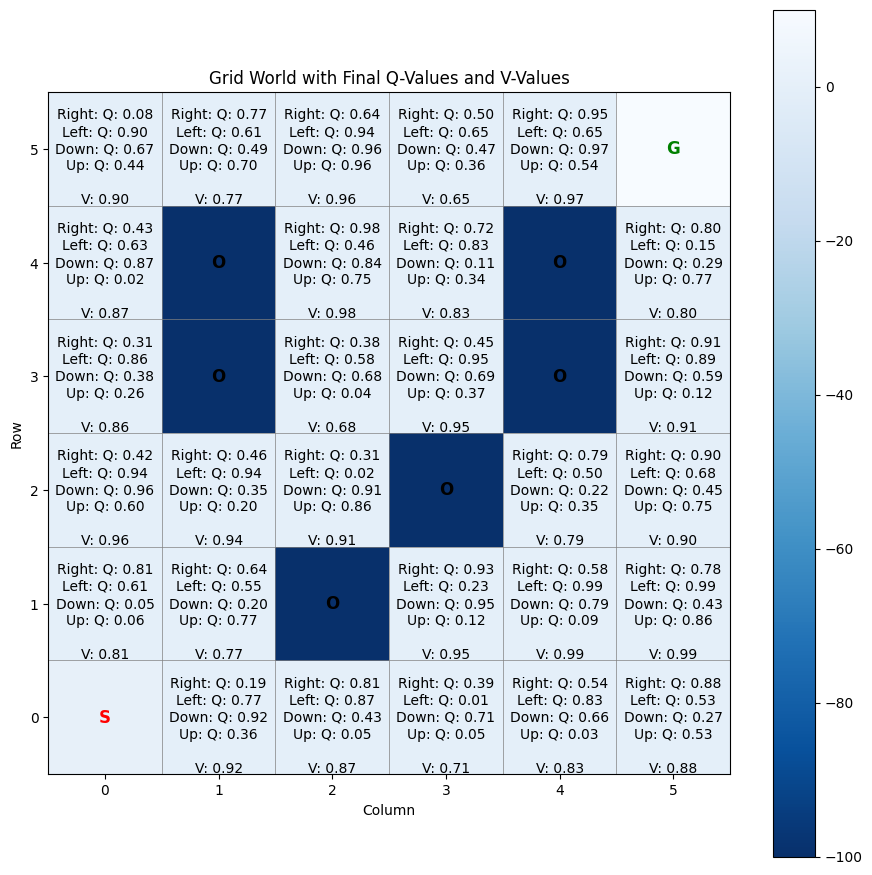

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Defining grid parameters and obstacle states
GRID_HEIGHT = 6
GRID_WIDTH = 6
OBSTACLE_STATES = [(1, 2), (2, 3),(3,1) ,(3, 4), (4,1),(4, 4)]
ACTIONS = ['Up', 'Down', 'Left', 'Right']
NUM_ACTIONS = len(ACTIONS)

# Define a function to display the grid world with values
def display_grid_with_final_values(q_values, v_values):
    # Create the grid
    grid = np.zeros((GRID_HEIGHT, GRID_WIDTH))

    # Mark obstacles
    for obstacle in OBSTACLE_STATES:
        grid[obstacle] = -100

    # Mark start and goal
    grid[0, 0] = 1  # Start
    grid[GRID_HEIGHT - 1, GRID_WIDTH - 1] = 10  # Goal

    # Create a larger figure for better visualization
    plt.figure(figsize=(11, 11))

    # Plot the grid with values
    plt.imshow(grid, cmap='Blues_r', interpolation='none', origin='upper')
    for i in range(GRID_WIDTH + 1):
        plt.axvline(i - 0.5, color='gray', linestyle='-', linewidth=0.5)
    for i in range(GRID_HEIGHT + 1):
        plt.axhline(i - 0.5, color='gray', linestyle='-', linewidth=0.5)

    for i in range(GRID_HEIGHT):
        for j in range(GRID_WIDTH):
            if grid[i, j] == 1:
                plt.text(j, i, 'S', ha='center', va='center', fontsize=12, fontweight='bold', color='red')
            elif grid[i, j] == 10:
                plt.text(j, i, 'G', ha='center', va='center', fontsize=12, fontweight='bold', color='green')
            elif grid[i, j] == -100:
                plt.text(j, i, 'O', ha='center', va='center', fontsize=12, fontweight='bold', color='black')
            else:
                for a, action in enumerate(ACTIONS):
                    plt.text(j, i + 0.15 * (a - 1), f'{action}: Q: {q_values[i, j, a]:.2f}', ha='center', va='center', fontsize=10, color='black')
                plt.text(j, i - 0.15 * (NUM_ACTIONS - 1), f'V: {v_values[i, j]:.2f}', ha='center', va='center', fontsize=10, color='black')

    plt.title('Grid World with Final Q-Values and V-Values')
    plt.xlabel('Column')
    plt.ylabel('Row')
    plt.xticks(range(GRID_WIDTH))
    plt.yticks(range(GRID_HEIGHT))
    plt.gca().invert_yaxis()
    plt.colorbar()

# Sample final Q-values and V-values
final_q_values = np.random.rand(GRID_HEIGHT, GRID_WIDTH, NUM_ACTIONS)
final_v_values = np.max(final_q_values, axis=2)

# Display the grid world with final Q-values and V-values
display_grid_with_final_values(final_q_values, final_v_values)

plt.show()
